<a href="https://colab.research.google.com/github/RafaelSapia/projetos_data_science/blob/master/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 2.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## O Projeto

Com o **intuito de reduzir ao máximo o *churn rate*** (taxa de cancelamento), será feito aqui o uso de **técnicas de machine learning** para identificar as semelhanças entre os usuários que cancelaram a assinatura em uma companhia de telecomunicações e assim, prever quais clientes são mais propensos a desistir.

Usar inteligência artificial para otimizar a identificação de potenciais clientes que cancelarão sua assinatura é altamente recomendável, pois **os resultados obtidos são extremamente satisfátórios** e a melhoria do modelo preditivo é feita constantemente mesmo com ele em produção, o que significa que a taxa de previsão do modelo tende sempre a melhorar.

Com esses dados fornecidos pelo modelos em mãos, a empresa pode **direcionar para os clientes identificados, promoções, novas experiências de usuário e novas campanhas de marketing de modo a reverter a vontade do cliente de desistir do produto**. Além disso, a empresa pode também identificar os motivos que mais pesaram para a desistência dos usuários e corrigir aqueles que forem em relação à empresa ou ao produto. Todos estes processos possuem um custo adicional para a empresa e ai está mais um ponto para o uso de inteligência artificial neste caso, os custos são reduzidos em relação ao que se gastaria com outros tipos de soluções, pois com o direcionamento e a eficiência que essa ferramenta proporciona é fato que **os custos serão os menores possíveis**.

Iniaremos importando as bibliotecas que serão utilizadas.

In [50]:
# importando bibliotecas

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

%matplotlib inline
sns.set()

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam, como já dito, de um problema de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíveis, os nomes das colunas permitem um entendimento a respeito do problema.

In [51]:
# importar os dados


DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas e o tamanho do dataset


print(" O conjunto de dados possui {} entradas e {} colunas".format(df.shape[0], df.shape[1]))
df.head()

 O conjunto de dados possui 7043 entradas e 21 colunas


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Podemos ver que o conjunto de dados possui uma grande quandidade de entradas e uma boa quantidade de informações sobre cada uma delas.

Cada variável (coluna) possui um nome que explica bem o que ela informa sobre cada cliente, que são representados por cada entrada (linha).

Logo de cara podemos notar que a variável `customerID` não tem nenhum significado relevante, somente é um código para a diferenciação dos clientes, portanto iremos retirá-la.

Uma informação não informada mas que é relevante é o fato da coleta destes dados terem sido feitas em um determinado intervalo de tempo.

In [52]:
# retirando customerid

df = df.drop('customerID', axis=1)

Para facilitar o entendimento, apresentarei aqui uma síntese do significado de cada uma das variáveis.

* `customerID` - Código de identificação de cada cliente
* `gender` - Gênero do cliente 
* `SeniorCitizen` - Informa se o cliente se enquadra como idoso (1) ou não idoso (0)
* `Partner` - Informa se o cliente possui parceira ou parceiro
* `Dependents` - Informa se o cliente possui dependentes
* `tenure` - Mostra o grau de fidelidade do cliente. É um número baseado basicamente no tempo que o indivíduo é cliente da empresa.
* `PhoneService` - Indica se o cliente assina o serviço de telefone residencial da empresa
* `MultipleLines` - Indica se o cliente possui o plano de multiplas linhas da empresa
* `InternetService` - Indica se o cliente possui o serviço de internet da empresa. Caso ele possua, indica também o tipo da internet, fibra ótica ou DSL
* `OnlineSecurity` - Mostra se o cliente contrata o serviço de segurança online da empresa
* `OnlineBackup` - Indica se o cliente possui o serviço de backup online da empresa
* `DeviceProtection` - Indica se o cliente possui o serviço de proteção de dispositivo fornecido pela empresa
* `TechSupport` - Indica de o cliente contrata o suporte técnico da empresa
* `StreamingTV` - Indica se o cliente possui algum serviço de TV por assinatura de terceiros
* `StreamingMovies` - Indica se o cliente possui algum serviço de transmissão de filmes de terceiros
* `Contract` - Indica o tipo de contrato que o cliente possui com a empresa, mensal, anual ou bienal
* `PaperlessBilling` - Indica se o cliente paga a fatura por boleto ou digitalmente
* `PaymentMethod` - Indica a forma de pagamento efetuada pelo cliente que pode ser por cartão de crédito, cobrança por e-mail, cheque eletrônico ou transferência bancária  
* `MonthlyCharges` - Indica o quanto o cliente paga por mês pelos serviços contratados por ele
* `TotalCharges` - Indica o quanto o cliente teve de despesas em todo o período avaliado no *dataset*
* `Churn` - Indica se o cliente desistou ou não das suas assinaturas

## Análise inicial

Iniciaremos agora as primeiras análises em cima do conjunto de dados. Estes primeiros resultados servem para conhecer melhor o *dataset*, se familiarizar com as informações apresentadas e identificar quais tratamentos deverão ser feitos em cima deste conjunto de dados.

In [53]:
# verificando tipo das variáveis e a existência de valores nulos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Um ponto positivo é a inexistência de valores nulos, o que facilita o processo de tratamento dos dados.

Porém, podemos observar que a grande maioria das variáveis estão com o Dtype como `object`. Isso significa que estas variáveis são do tipo categóricas, e isso é um grande problema para a maioria dos modelos de machine learning. 

Por isso, será necessário transformar estas variáveis em variáveis numéricas no momento do tratamendo dos dados.

Note que a variável `TotalCharges` apresenta números no dataset, porém ela está como categórica. Para não ter problemas mais pra frente, esta será a unica alteração feita agora.

In [54]:
# mudando tipo de totalcharges

df.TotalCharges = df.TotalCharges.replace(' ', np.nan).astype(float)
df.TotalCharges = df.TotalCharges.fillna(df.TotalCharges.median())

Além de fazer de fato a conversão para de `TotalCharges` para uma variável numérica foi necessário preencher algumas entradas que estavam sem valor. Esse valores não eram nulos, por isso não foram acusados na análise acima.

Foi completado tais entradas com a mediana da variável, pois observando apenas os primeiros 5 valores para essa variável mostrados acima, ja é possível perceber uma grande discrepância entre eles, o que pode significar a presença de *outliers*. 

Mais para frente será feita uma análise mais minuciosa em relação à presença de *outliers* no *dataset*.

In [55]:
# vendo quantidade de valores unicos por variável

df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Acima é mostrado a quantidade de valores únicos para cada variável.

Todas estas variáveis que possuem baixa quantidade de valores únicos (de 2 a 4) são variáveis categóricas. A grande maioria das variáveis, aquelas que possuem 2 e 3 valores distintos consideraremos binárias, pois elas normalmente apresentam este comportamento, por exemplo: 'Yes'/'No', ou então 'Yes'/'No/'No phone device'.

Portanto, o tratamento destas ocorrerá trocando valores positivos do tipo 'Yes' por 1 e valores negativos como 'No...' por 0. As variáveis categóricas que não apresentam esse comportamento binário receberão tratamento com `get_dummies` do pandas. Este tratamento evita que o modelo entenda errado a informação contida nestas variáveis.

In [56]:
# verificando outliers nas variáveis numéricas não binárias


num = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_num = df[num].copy()
df_num.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.916928
std,24.559481,30.090047,2265.270398
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


A principício podemos dizer que tanto `tenure`, quanto `MonthlyCharges` provavelmente não possuem *outliers*. Porém, para `TotalCharges` observamos um valor máximo aparentemente longe dos demais. 

Para verificar esta hipótese de *outlier* em `TotalCharges` vamos ver o boxplot para essa variável.

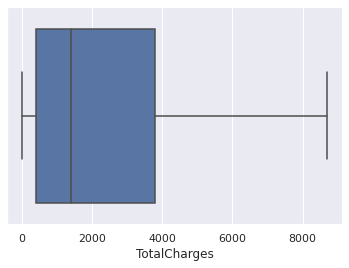

In [57]:
# boxplot para totalcharges

fig, ax = plt.subplots()

sns.boxplot(df.TotalCharges, ax=ax, orient='h')
plt.show()

Apesar de do valor máximo para essa variável ser maior que a grande maioria, vemos que ele ainda está dentro do limite superior do boxplot, portanto não consideraremos *outlier*.

## Visualização dos dados

Começaremos a etapa de visualização dos dados presentes no *dataset* que estamos trabalhando. A visualização permite uma geração muito grande de insights, portanto nesta etapa o intuito principal é gerar o máximo de insights possíveis a cerca do conjunto de dados.

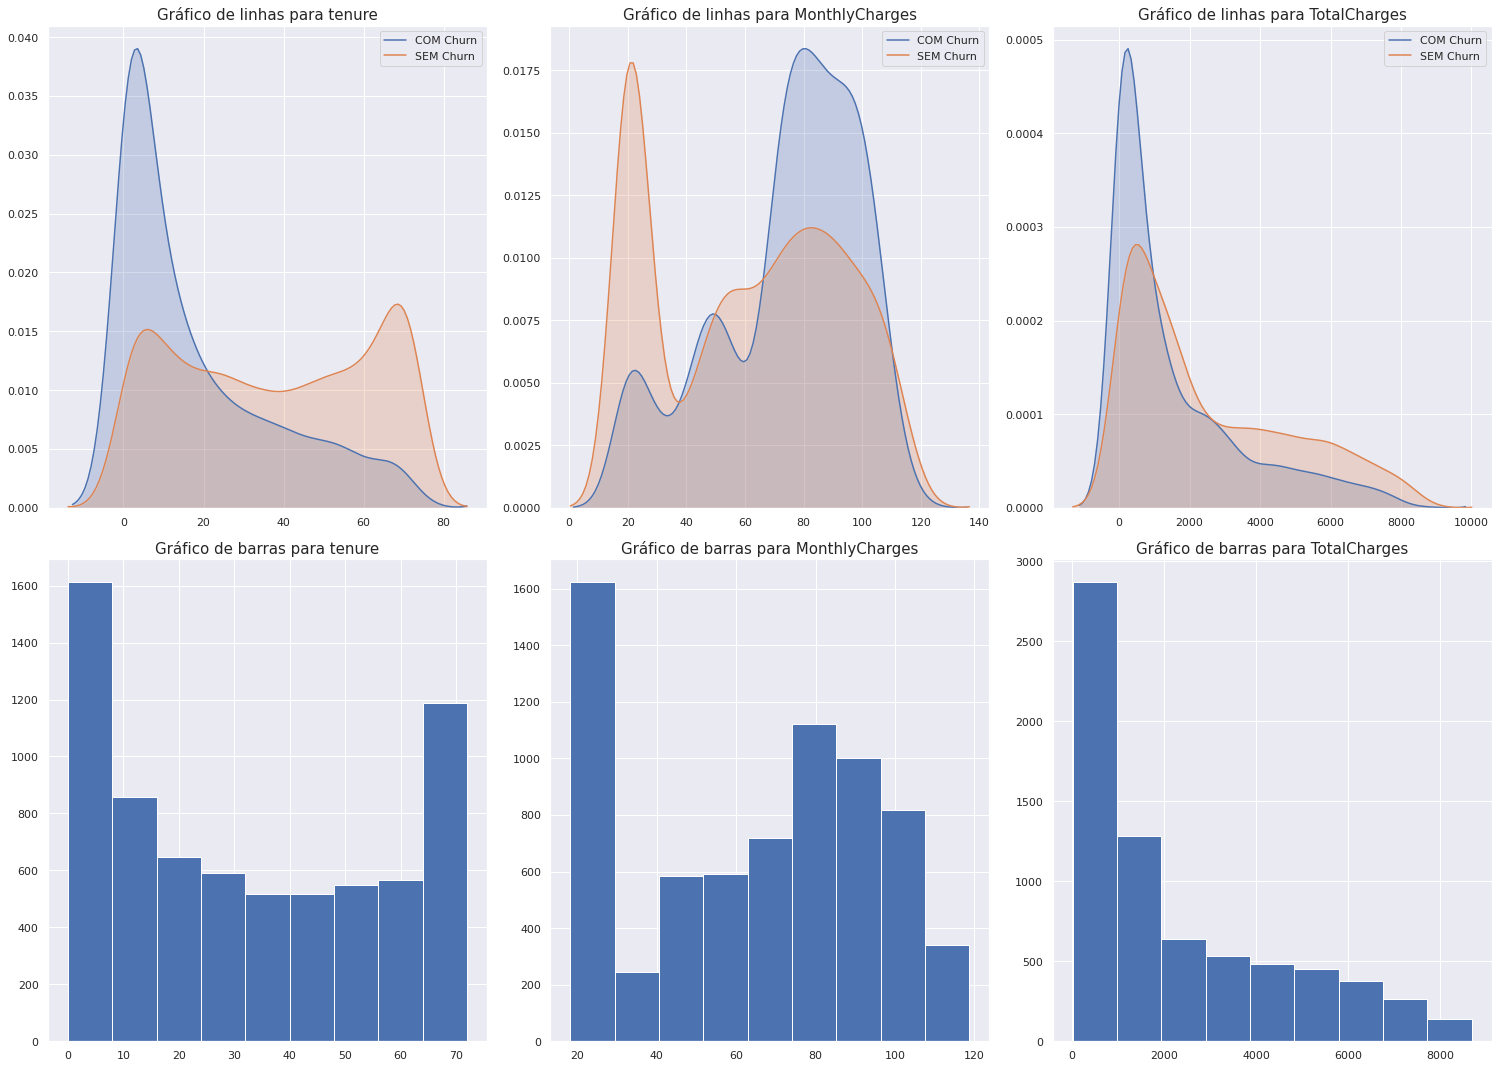

In [58]:
# vendo comportamento gráfico das variáveis numéricas não binárias

fig, ax = plt.subplots(2, 3, figsize=(21,15))

for lin,col,i in zip(range(3), range(3),df_num.columns):

  lin = 0

  sns.kdeplot(df[df.Churn == 'Yes'][str(i)], shade=True, label='COM Churn', ax=ax[lin][col])
  sns.kdeplot(df[df.Churn == 'No'][str(i)], shade=True, label='SEM Churn', ax=ax[lin][col])
  ax[lin][col].set_title('Gráfico de linhas para {}'.format(i), size=15)
  

  lin += 1

  ax[lin][col].hist(df_num[str(i)], bins=9)
  ax[lin][col].set_title('Gráfico de barras para {}'.format(i), size=15)


  
plt.tight_layout()

Observando estes gráficos podemos tirar alguns *insights*:

 * Pessoas com `tenure` baixo tendem a abandonar a empresa, ou seja, que possuem um grau de fidelidade baixo com a empresa, que são clientes recentes, tendem a desistir com mais frequência da empresa.
 * Pessoas com `MonthlyChargers` mais elevados são mais propensos a abandonar, ou seja, aquelas pessoas que tem uma despesa mais elevada com a empresa tendem a desistir mais dela.



In [59]:
# criando conjunto de dados com variáveis binárias para visualização dos dados 

val_bin = df.drop(['tenure', 'TotalCharges', 'MonthlyCharges'], axis=1)

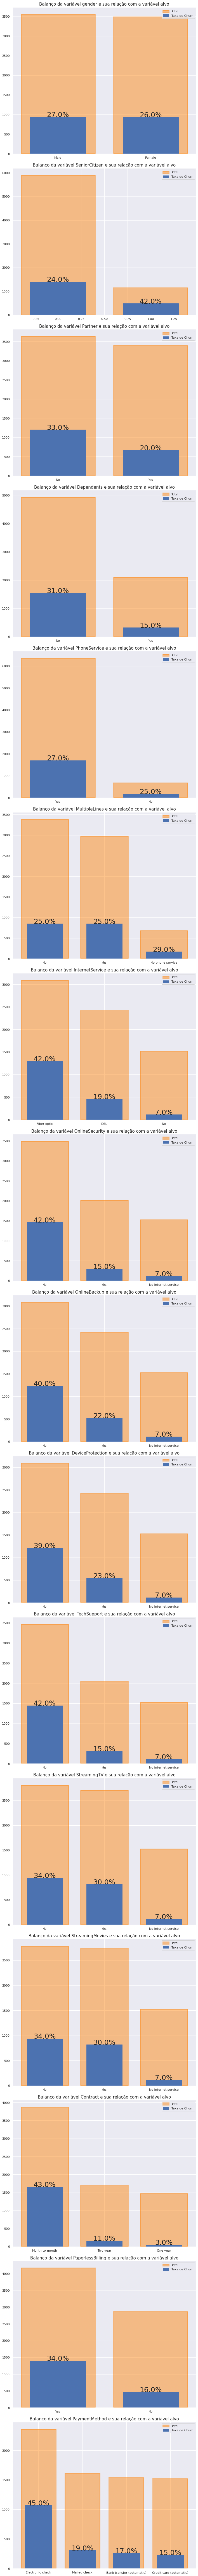

In [60]:
# visualizando gráfico de barras para cada variável binária com a porcentagem de 
# abandono para cada barra


def num_text(k, lin):
    return ax[lin].text(k,val_bin[val_bin['Churn']=='Yes'][str(i)].value_counts()[k],
        '{}%'.format(round(((val_bin[val_bin['Churn']=='Yes'][str(i)].value_counts()/val_bin[str(i)].value_counts())[k])*100),1),
        horizontalalignment='center', size=25)
    

fig, ax = plt.subplots(16, 1, figsize=(10,128))


for lin, i in zip(range(16),val_bin.columns):
  ax[lin].bar(val_bin[str(i)].value_counts().index,val_bin[str(i)].value_counts(),
       color='#ff8000',alpha=0.45,edgecolor='#ff8000',linewidth=3,label='Total')
  ax[lin].bar(val_bin[str(i)].value_counts().index,
       val_bin[val_bin['Churn']=='Yes'][str(i)].value_counts(),
       color='b', width=0.6, edgecolor='b',label='Taxa de Churn')
  for k in range(len(val_bin[str(i)].value_counts())):
    num_text(k, lin)
  ax[lin].set_title('Balanço da variável {} e sua relação com a variável alvo'.format(i), size=15)
  ax[lin].legend(loc='best')

plt.tight_layout()

Primeiramente, note que a **variável alvo**, ou seja, a variável que é o foco deste projeto, é a **variável `Churn`**. É ela que indica se determinado cliente desistiu ou não dos serviços da empresa de telecomunicações em questão. 

Por esse motivo, nos gráficos acima, temos uma barra azul representando a taxa de Churn, ou seja, a proporção entre o total de pessoas que atendem à uma determinada característica e que desistiram dos serviços da empresa.

Por exemplo, 27% dos homens presentes no *dataset* desistiram dos serviços da empresa de telecomunicações.

A cerca dos gráficos acima podemos tirar alguns insights:

 * O gênero não impacta na desistência do serviço
 * Pessoas idosas possuem uma taxa de abandono alta
 * Pessoas que não possuem parceiros(as) tem uma taxa de abandono consideravelmente maior do que as pessoas que possuem.
 * Pessoas que não possuem dependentes tem uma taxa de abandono maior que pessoas que possuem dependentes. 
 * Quase metade dos clientes que possuem internet por fibra ótica desistiram dos serviços da empresa de telecomunicações.
 * Pessoas que não contrataram serviços adicionais da empresa como plano de segurança online, plano de backup online, plano de proteção de dispositivo, suporte técnico tem uma tendência maior em desistir da companhia de telecomunicação.
 * Pessoas que tem um contrato mensal com a empresa tendem a desistir numa taxa muito maior que as pessoas que tem contratos anuais ou bienais.
 * Pessoas que optaram pela fatura digital tem uma maior taxa de desistência.
 * Praticamente metade das pessoas que pagam por cheque eletrônico desistiram dos serviços da empresa, enquanto que a taxa de desistência para os outros métodos de pagamento é bem menor.

26.54% dos clientes desistiram dos serviços


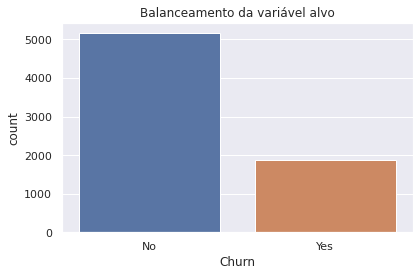

In [61]:
# verificando balanceamento da variável alvo

fig, ax = plt.subplots()

print('{}% dos clientes desistiram dos serviços'.
      format(round((val_bin[val_bin.Churn =='Yes'].shape[0] / val_bin.shape[0])*100,2)))
sns.countplot(val_bin.Churn, ax=ax)
ax.set_title('Balanceamento da variável alvo')
plt.tight_layout()

Pelo gráfico acima vemos que existe uma diferença considerável entre a quantidade de clientes que abandonaram os serviços de telecomunicações e aqueles que não abandonaram. Apenas 26% dos clientes desistiram.

Antes da construção dos modelos preditivos será necessário o balanceamento da variável alvo para que o desempenho do modelo não seja prejudicado.

## Tratamento dos Dados

Começaremos agora a tratar os dados do *dataset*. Esta parte é importante, pois precisamos que os dados estejam tratados para conseguirmos treinar os modelos de previsão sem que eles fiquem inviesados.

Aqui transformaremos as variáveis categóricas em numéricas, utilizando o `LabelEncoder` do scikit-learn e o `get_dummies` do pandas.

Quando estivermos mais próximos da construção do modelo de fato será feito um complemento do tratamento de dados que chamamos de *Feature Engineering*. Nesta parte mexeremos um pouco mais nos dados com algumas outras técnicas com o intuito de conseguir o melhor desempenho dos modelos.

In [62]:
# transformando as variáveis categóricas em numéricas

df_trans = df.copy()


def trans_cat(cat):
  if len(cat.unique()) == 2:
    return trans.fit_transform(cat)
  else:
    return cat

trans = LabelEncoder()
df_trans = df_trans.apply(trans_cat)


obj = [col for col in df_trans.columns if df_trans[str(col)].dtype == 'O']
df_trans = pd.get_dummies(df_trans, columns=obj)

df_trans.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Nas variáveis realmente binárias, ou seja, aquelas variáveis categóricas que só tinham dois valores possíveis foi usado `LabelEncoder` e nas variáveis que possuiam 3 ou 4 valores possíveis foi usado o `get_dummies` com o intuito de preservar todas a informações fornecidas inicialmente por essas colunas.

## Modelo base

Construiremos agora um modelo base, a chamada *baseline*. O objetivo inicial com o nosso modelo real que será construido em breve é superar o desempenho deste que vamos construir agora.

Este que vamos contruir agora trata-se de um modelo simples, sem ajustes e balanceamentos.

In [63]:
# baseline com random forest

base = RandomForestClassifier()

X_base = df_trans.drop('Churn', axis=1)
y_base = df_trans.Churn

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,y_base,
                                                                        random_state=123)

cross_recall = cross_val_score(base, X_train_base, y_train_base, scoring='recall', cv=5)
print('Recall : %0.2f (+/- %0.2f)' % (cross_recall.mean(), cross_recall.std() * 2))
cross_precision = cross_val_score(base, X_train_base, y_train_base, scoring='precision', cv=5)
print('Precisão : %0.2f (+/- %0.2f)' % (cross_precision.mean(), cross_precision.std() * 2))

Recall : 0.48 (+/- 0.03)
Precisão : 0.63 (+/- 0.04)


Podemos ver que o modelo obteve um recall de 48% para pessoas que desistiram, precisão de 63%. Portando, os modelos que criaremos deverão, no mínimo, superar este. 

## Balanceamento e divisão dos dados

Iniaremos agora a preparação final antes de iniciar de fato a construção e avaliação dos modelos para prever a desistência de clientes. 

Aqui realizaremos o balanceamento da variável alvo (Churn) tanto pelo método de *undersampling* quanto pelo de *oversampling*. Durante a validação dos modelos treinaremos cada um duas vezes, uma vez com os dados que receberam *oversampling* e os dados que receberam *undersampling*.

Ainda não realizaremos a padronização dos dados utilizando o `StandardScaler`, pois a próxima etapa consiste na utilização do *cross validation* para a verificação do modelo que melhor se desempenha. 

Para este algoritmo de validação cruzada não é interessante que todos os dados de treino estejam padronizados. Será feita uma padronização, mas não de todos os dados de treino. A padronização total destes dados ocorrerá quando decidirmos qual é o melhor modelo para a previsão de desistência.

In [64]:
# realizando divisão das variáveis explanatórias e variável alvo

X = df_trans.drop('Churn', axis=1)
y = df_trans.Churn 

# dividindo os dados entre treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1234)

# realizando método de under sampling

under = RandomUnderSampler()
X_train_rus, y_train_rus = under.fit_sample(X_train, y_train)

# realizando método de over sampling

over = SMOTE()
X_train_smo, y_train_smo = over.fit_sample(X_train, y_train)

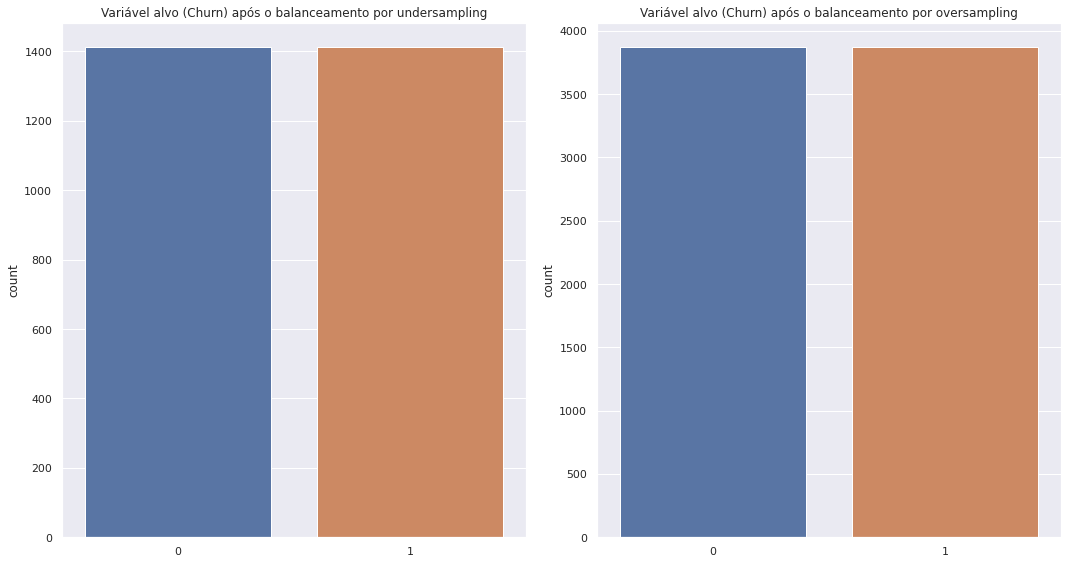

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

sns.countplot(y_train_rus, ax=ax1)
ax1.set_title('Variável alvo (Churn) após o balanceamento por undersampling')

sns.countplot(y_train_smo, ax=ax2)
ax2.set_title('Variável alvo (Churn) após o balanceamento por oversampling')

plt.tight_layout()

Note a diferença do balanceamento por *undersampling* e *oversampling*. No método de *oversampling* são criadas entradas novas baseadas nas que já existem da classe que possui menor quantidade.

Já em *undersampling* é o contrário, retira-se entradas da classe que possui maior quantidade.

## Construindo modelos

Finalmente iniciaremos a etapa de construção e posteriormente a seleção do modelo que obteve o melhor desempenho.

Utilizaremos modelos de aprendizado supervisionado já que no nosso conjunto de dados temos uma variável alvo como já dito.

Utilizando o método de *cross validation* vários modelos serão avaliados utilizando algumas métricas. Para que se possa ter uma noção mais ampla sobre o desempenho de cada modelo, colocarei várias métricas de avaliação, porém existem métricas que neste caso são mais importantes que outras.

Neste caso de previsão de desistência o que queremos é que o modelo sempre acerte se determinado vai desistir. A métrica que mede o quanto o modelo previu corretamente em relação à todos os clientes que realmente desistiram é o recall, portanto essa é a métrica que deve ser mais considerada no momento de escolher o melhor modelo, é ela que queremos otimizar neste caso. 

Mas atente-se, não devemos olhar somente para ela. A métrica de precisão é muito importante aqui também, pois ela indica o quanto o modelo acertou em relação à todos os clientes que o modelo disse que iriam desistir. Caso a precisão seja baixa significa que o modelo teve muitos falsos positivos, o que pode gerar prejuizo para a empresa supondo que ela invista mais nesses clientes que o modelo disse que irão desistir com o intuito de mantê-los como clientes.

Uma outra métrica importante para conjunto de dados desbalanceados como este é a área abaixo da curva ROC. Esta métrica indica o quão bom foi o desempenho do nosso modelo, sua escala vai de 0 a 1 e quando mais próximo de 1, melhor.

In [66]:
# instanciando os modelos que serão testados e testando-os perante os valores
# com o método under sampling

lr = LogisticRegression()
xgb = XGBClassifier()
dt = DecisionTreeClassifier()
sgd = SGDClassifier()
rf = RandomForestClassifier()
svc = SVC()

def valid(model,X,y):
  final = []

  X = np.array(X)
  y = np.array(y)

  pipe = make_pipeline(StandardScaler(), model)

  tup_metrics=('recall', 'precision', 'f1', 'roc_auc', 'accuracy')
  for metric in tup_metrics:
    final.append(cross_val_score(pipe,X,y,scoring=metric,
                                 cv=5).mean())
  return final


model_name_under = []
metricas = []


for model_under in (lr, xgb, dt, sgd, rf, svc):
  model_name_under.append(model_under.__class__.__name__)
  metricas.append(valid(model_under,X_train_rus,y_train_rus))

pd.DataFrame(metricas, index=model_name_under, columns=['recall', 'precision', 'f1', 'roc_auc', 'accuracy'])

,recall,precision,f1,roc_auc,accuracy
LogisticRegression,0.798852,0.743844,0.769778,0.848436,0.760970
XGBClassifier,0.811603,0.757937,0.783400,0.849689,0.775491
DecisionTreeClassifier,0.689091,0.689352,0.694587,0.692280,0.691927
SGDClassifier,0.730153,0.713510,0.739609,0.771937,0.731232
RandomForestClassifier,0.786121,0.759403,0.776400,0.841446,0.764868
SVC,0.787525,0.747379,0.766226,0.831219,0.759553


Acima fizemos a avaliação com *cross validation* de vários modelos em relação aos dados que receberam o método de *undersampling*.

Podemos observar 3 modelos que se destacaram, são eles:

 * Regressão logística
 * XGBoost
 * Máquina de vetor de suporte (SVC)

Destes três, o XGBoost obteve o maior recall que é a métrica mais importante para nós, além disso ele obteve pontuação maior em todas as outras métricas. 

Ainda temos que avaliar o desemprenho desses modelos perante os dados que receberam *oversampling*, mas existem grandes chances do XGBoost ser o escolhido para fazer a construção do modelo final do projeto.

In [67]:
# avaliando os modelos em relação aos dados que receberam over sampling

model_name_over = []
metricas_over = []


for model_over in (lr, xgb, dt, sgd, rf, svc):
  model_name_over.append(model_over.__class__.__name__)
  metricas_over.append(valid(model_over,X_train_smo,y_train_smo))

pd.DataFrame(metricas_over, index=model_name_over, columns=['recall', 'precision', 'f1', 'roc_auc', 'accuracy'])

,recall,precision,f1,roc_auc,accuracy
LogisticRegression,0.809044,0.752855,0.779874,0.858078,0.771576
XGBClassifier,0.816021,0.866737,0.823839,0.943388,0.845607
DecisionTreeClassifier,0.796899,0.802351,0.786402,0.801996,0.801292
SGDClassifier,0.792506,0.746310,0.765279,0.819526,0.760724
RandomForestClassifier,0.809819,0.873819,0.824188,0.941924,0.848062
SVC,0.817571,0.826771,0.817162,0.919555,0.823385


Observando estes últimos resultados podemos concluir duas coisas:

 * O algoritmo de XGBoost será o usado para fazer a construção do modelo final
 * Os dados que receberam *oversampling* serão os usados para o treinamento do modelo final

## Padronizando os dados de treino

Faremos agora a padronização dos dados de treino que passando por *oversampling* para posteriormente inicial o tune dos parametros do XGBoost.


In [68]:
# padronizando os dados com over sampling

scaler = StandardScaler().fit(X_train_smo)
x_train_smo = scaler.transform(X_train_smo)

## Modelo final

Iniciaremos a contrução do modelo final. Como já dito, será usado aqui como algoritmo o XGBoost e como dados de treino aqueles que receberam o *oversampling*.

Inicialmente será feito o tuning dos parâmetros do algoritmo usando o `GridSearchCV`. 

E por fim a passagem dos dados de teste no modelo para atestar sua eficácia em produção.

In [69]:
# utilizando grid search para gamma

xgb = XGBClassifier()

params = {
    'gamma': np.arange(1, 100, 1)
}

grid = GridSearchCV(xgb, params, 'f1', n_jobs=-1, cv=5)

result = grid.fit(X_train_smo, y_train_smo)

print('f1: {} com {}'.format(result.best_score_,result.best_params_))

f1: 0.83245133313544 com {'gamma': 30}


Um dos parâmetros mais importantes para o algoritmo XGBoost é o `gamma`, por isso começei otimizando ele, tanto ele quando o prómixmo que otimizarei previnem o overfitting do modelo.
O próximo será o `learning_rate`.

In [70]:
# utilizando grid search para learning rate

xgb = XGBClassifier(gamma=30)

params = {
    'learning_rate': np.arange(0 ,0.11, 0.01),
}

grid = GridSearchCV(xgb, params, 'f1', n_jobs=-1)

result = grid.fit(X_train_smo, y_train_smo)

print('f1: {} com {}'.format(result.best_score_,result.best_params_))

f1: 0.8337791810691437 com {'learning_rate': 0.06}


Estamos com um bom f1 score, mas ainda temos mais parâmetros para otimizar. É necessário neste momento comentar o motivo de estarmos tunando os hiperparâmetros do modelo utilizando a métrica de f1 sendo que como já comentado a métrica de recall é a que queremos otimizar aqui.

o f1 score é uma média harmônica do recall e da precisão. Seu cálculo é feito pela expressão abaixo:

\begin{equation*}
F1score = 2 * \frac {Recall * Precisão}{Recall + Precisão}
\end{equation*}

Otimizando o valor de f1 estaremos conseguindo um maior valor para precisão e para recall, claro o aumento do recall neste caso é menor do que seria seu aumento caso estivessemos focados em otimizar somente ele. 

Porém ainda assim é preferível otimizar o f1, pois conseguimos um aumento na precisão, o que é importante para esse projeto, visto que aumentando o valor desta métrica teremos uma diminuição de falsos positivos, ou seja, diminuiremos as ocorrências onde o modelo diz que o cliente vai desistir, mas na verdade ele não desiste.

Situações como essa citada acima podem trazer prejuízo para a empresa como ja explicado anteriormente.

In [71]:
# utilizando grid search para max depth e min child weight

xgb = XGBClassifier(gamma=30, learning_rate=0.06)

params = {
    'max_depth': np.arange(1, 10, 1),
    'min_child_weight': np.arange(1, 10, 1)
}

grid = GridSearchCV(xgb, params, 'f1', n_jobs=-1)

result = grid.fit(X_train_smo, y_train_smo)

print('f1: {} com {}'.format(result.best_score_,result.best_params_))

f1: 0.8337791810691437 com {'max_depth': 3, 'min_child_weight': 1}


Note que como se trata de uma métrica complexa, ou seja, que envolve duas outras métricas, os acréssimos que conseguimos aparentemente não são muito substanciais, porém caso estivessemos observando o recall e a precissão separados veriamos um aumento maior.

In [72]:
# utilizando grid search para colsample_bytree

xgb = XGBClassifier(gamma=30, learning_rate=0.06, max_depth=3,
                    min_child_weight=1)

params = {
    'colsample_bytree': np.arange(0.1, 1.1, 0.1)
}

grid = GridSearchCV(xgb, params, 'f1', n_jobs=-1)

result = grid.fit(X_train_smo, y_train_smo)

print('f1: {} com {}'.format(result.best_score_,result.best_params_))

f1: 0.8337791810691437 com {'colsample_bytree': 1.0}


In [73]:
# utilizando grid search para n_estimators

xgb = XGBClassifier(gamma=30, learning_rate=0.06, max_depth=3,
                    min_child_weight=1, colsample_bytree=1.0)

params = {
    'n_estimators': np.arange(20, 420, 20)
}

grid = GridSearchCV(xgb, params, 'f1', n_jobs=-1)

result = grid.fit(X_train_smo, y_train_smo)

print('f1: {} com {}'.format(result.best_score_,result.best_params_))

f1: 0.8355589224171089 com {'n_estimators': 60}


Finalizamos a parte de tuning dos hiperparâmetros do modelo e vamos agora partir para a parte final. 

Faremos a previsão a partir de dados que o modelo nunca teve contato e veremos se o desempenho obtido até agora se confirma para estes dados e se este desempenho é satisfatório para o problema que temos.

              precision    recall  f1-score   support

           0       0.96      0.45      0.62      1304
           1       0.38      0.95      0.54       457

    accuracy                           0.58      1761
   macro avg       0.67      0.70      0.58      1761
weighted avg       0.81      0.58      0.60      1761

AUC ROC: 0.699258131854855


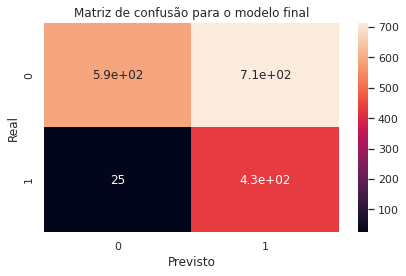

In [74]:
# treinando modelo final

xgb = XGBClassifier(gamma=30, learning_rate=0.06, max_depth=3,
                    min_child_weight=1, colsample_bytree=1.0,
                    n_estimators=60)
xgb.fit(X_train_smo, y_train_smo)

# fazendo previsão para os dados de teste

X_test = scaler.transform(X_test)
y_prev = xgb.predict(X_test)

# avaliando desempenho do modelo

print(classification_report(y_test, y_prev))
print("AUC ROC: {}".format(roc_auc_score(y_test, y_prev)))

fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_prev), ax=ax, annot=True)
ax.set_ylabel('Real')
ax.set_xlabel('Previsto')
ax.set_title('Matriz de confusão para o modelo final')
plt.tight_layout()

## Conclusão

Observando as métricas feitas em cima do modelo final vemos que o recall, a métrica mais importante neste caso, obteve um bom desempenho.

Precisão, f1, e acurácia não tiveram um bom desempenho, mas isso é aceitável, visto que para otimizar uma métrica inevitavelmente outra será penalizada.

Os desafios seguintes em relação ao modelo seriam ir mais fundo em *feature engineering* e testar uma gama maior de algoritmos com o objetivo de transferir o máximo de falsos positivos pro local que eles deveriam estar, nos verdadeiros negativos.

De modo geral podemos dizer que tivemos um desempenho satisfatório, devido ao bom recall de 95%. A cada 100 clientes que desistirem nosso modelo tem capacidade para identificar 95 deles.

Muito obrigado se você chegou aqui, peço que qualquer sugestão de melhoria ou elogio seja reportado a mim. Este em especial foi um projeto que aprendi bastante fazendo e tentei dar meu melhor. Até mais!

